In [ ]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.4.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:3 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [966 kB]
Get:8 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,235 kB]
Get:11 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [993 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com/ubu

In [ ]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder\
    .appName("SparkSQL")\
    .config("spark.sql.debug.maxToStringFields", 2000)\
    .config("spark.driver.memory", "2g")\
    .getOrCreate()

# Set the partitions to 4 or 8.
spark.conf.set("spark.sql.shuffle.partitions", 8)

In [ ]:
# Read in data from S3 Bucket
from pyspark import SparkFiles
url_listings = "http://data.insideairbnb.com/united-states/ny/new-york-city/2023-09-05/data/listings.csv.gz"
spark.sparkContext.addFile(url_listings)
listings_df = spark.read.csv(SparkFiles.get("listings.csv.gz"), sep=",", header=True, quote ='"', multiLine=True, escape = '"')

# Create a lookup table for calendar.
url_calendar="http://data.insideairbnb.com/united-states/ny/new-york-city/2023-09-05/data/calendar.csv.gz"
spark.sparkContext.addFile(url_calendar)
calendar_df = spark.read.csv(SparkFiles.get("calendar.csv.gz"), sep=",", header=True, quote ='"', multiLine=True, escape = '"')

# Create a lookup table for the airport codes.
url_reviews ="http://data.insideairbnb.com/united-states/ny/new-york-city/2023-09-05/data/reviews.csv.gz"
spark.sparkContext.addFile(url_reviews)
reviews_df = spark.read.csv(SparkFiles.get("reviews.csv.gz"), sep=",", header=True, quote ='"', multiLine=True, escape = '"')


In [ ]:
# Look over the listings data.
listings_df.show()

+------------------+--------------------+--------------+------------+-----------+--------------------+--------------------+---------------------+--------------------+---------+--------------------+---------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+------------------+------------------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+--------------

In [ ]:
# Look over the data for calendar.
calendar_df.show()

+----------+----------+---------+-------+--------------+--------------+--------------+
|listing_id|      date|available|  price|adjusted_price|minimum_nights|maximum_nights|
+----------+----------+---------+-------+--------------+--------------+--------------+
|      2595|2023-09-05|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-06|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-07|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-08|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-09|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-10|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-11|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-12|        t|$240.00|       $240.00|            30|          1125|
|      2595|2023-09-13|        t|$240.00|  

In [ ]:
# Look over the review data.
reviews_df.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|      2595|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|
|      2595|   19176|2009-12-05|      53267|         Cate|   Great experience.|
|      2595|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|
|      2595|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|
|      2595|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu...|
|      2595| 1238204|2012-05-07|    1783688|       Sergey|Hi to everyone!\r...|
|      2595| 1293632|2012-05-17|    1870771|         Loïc|Jennifer was very...|
|      2595| 2022498|2012-08-18|    2124102|      Melanie|This apartment is...|
|      2595| 4682989|2013-05-20|     496053|         Eric|Jennifer's place ...|
|      2595|13193832|2014-05-21|   13685

In [ ]:
import pandas as pd

In [ ]:
listings_df.count()

39453

In [ ]:
calendar_df.count()

14399996

In [ ]:
reviews_df.count()

1019573

In [ ]:
unique_neighbourhoods = listings_df.select('neighbourhood_cleansed').distinct()
unique_neighbourhoods_count = unique_neighbourhoods.count()
print("Count of unique neighbourhoods:", unique_neighbourhoods_count)

Count of unique neighbourhoods: 223


In [ ]:
accepted_neighborhoods = ["Manhattan", "Queens", "Brooklyn"]

In [ ]:
filtered_listings_df = listings_df[listings_df['neighbourhood_group_cleansed'].isin(accepted_neighborhoods)]


In [ ]:
filtered_listings_df.show()

+------------------+--------------------+--------------+------------+-----------+--------------------+--------------------+---------------------+--------------------+---------+--------------------+---------------+----------+--------------------+--------------------+------------------+------------------+--------------------+-----------------+--------------------+--------------------+------------------+-------------------+-------------------------+--------------------+--------------------+----------------------+--------------------+----------------------+----------------------------+------------------+------------------+--------------------+---------------+------------+---------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------------+----------------+----------------+---------------+---------------+---------------+------

In [ ]:
filtered_listings_df.count()

37609

In [ ]:
listing_columns = ['id','listing_url','name','host_id','host_url','host_name','host_since','host_is_superhost','host_listings_count','host_total_listings_count','neighbourhood_cleansed','neighbourhood_group_cleansed','latitude','longitude','room_type','accommodates','bathrooms_text','bedrooms','beds','amenities','price','minimum_nights','maximum_nights','has_availability','number_of_reviews','number_of_reviews_ltm','number_of_reviews_l30d','first_review','last_review','review_scores_rating','review_scores_accuracy','review_scores_cleanliness','review_scores_checkin','review_scores_communication','review_scores_location','review_scores_value','calculated_host_listings_count','reviews_per_month']
calendars_columns = ['listing_id','date','available','price','adjusted_price']
reviews_columns = ['listing_id','id','date','reviewer_id','reviewer_name','comments']

In [ ]:
column_listings_df = filtered_listings_df[listing_columns]
column_calendars_df = calendar_df[calendars_columns]
column_reviews_df = reviews_df[reviews_columns]

In [ ]:
column_listings_df = column_listings_df.withColumnRenamed('id', 'listing_id')

In [ ]:
column_listings_df.show()

+------------------+--------------------+--------------------+---------+--------------------+---------------+----------+-----------------+-------------------+-------------------------+----------------------+----------------------------+------------------+------------------+---------------+------------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------+-----------------+---------------------+----------------------+------------+-----------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+------------------------------+-----------------+
|        listing_id|         listing_url|                name|  host_id|            host_url|      host_name|host_since|host_is_superhost|host_listings_count|host_total_listings_count|neighbourhood_cleansed|neighbourhood_group_cleansed|          latitude|         longitude|      room_type|a

In [ ]:
from pyspark.sql import SparkSession


In [ ]:
# Initialize Spark session
spark = SparkSession.builder.appName("example").getOrCreate()

# Assuming you have a PySpark DataFrame named 'column_listings_df'
# Drop rows with null values in the 'listing_id' column
column_listings_df = column_listings_df.dropna(subset=['first_review'])

# Show the DataFrame after dropping null values
column_listings_df.show()

+------------------+--------------------+--------------------+---------+--------------------+---------------+----------+-----------------+-------------------+-------------------------+----------------------+----------------------------+------------------+------------------+---------------+------------+--------------+--------+----+--------------------+-------+--------------+--------------+----------------+-----------------+---------------------+----------------------+------------+-----------+--------------------+----------------------+-------------------------+---------------------+---------------------------+----------------------+-------------------+------------------------------+-----------------+
|        listing_id|         listing_url|                name|  host_id|            host_url|      host_name|host_since|host_is_superhost|host_listings_count|host_total_listings_count|neighbourhood_cleansed|neighbourhood_group_cleansed|          latitude|         longitude|      room_type|a

In [ ]:
column_listings_df.count()

27708

In [ ]:
column_reviews_df = column_reviews_df.dropna(subset=['comments'])
column_reviews_df.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|      2595|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|
|      2595|   19176|2009-12-05|      53267|         Cate|   Great experience.|
|      2595|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|
|      2595|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|
|      2595|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu...|
|      2595| 1238204|2012-05-07|    1783688|       Sergey|Hi to everyone!\r...|
|      2595| 1293632|2012-05-17|    1870771|         Loïc|Jennifer was very...|
|      2595| 2022498|2012-08-18|    2124102|      Melanie|This apartment is...|
|      2595| 4682989|2013-05-20|     496053|         Eric|Jennifer's place ...|
|      2595|13193832|2014-05-21|   13685

In [ ]:
column_reviews_df.count()

1019573

# **RUTVA'S CODE**

# **NLP**

In [ ]:
# Show DataFrame
column_reviews_df.show()

+----------+--------+----------+-----------+-------------+--------------------+
|listing_id|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+--------+----------+-----------+-------------+--------------------+
|      2595|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|
|      2595|   19176|2009-12-05|      53267|         Cate|   Great experience.|
|      2595|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|
|      2595|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|
|      2595|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu...|
|      2595| 1238204|2012-05-07|    1783688|       Sergey|Hi to everyone!\r...|
|      2595| 1293632|2012-05-17|    1870771|         Loïc|Jennifer was very...|
|      2595| 2022498|2012-08-18|    2124102|      Melanie|This apartment is...|
|      2595| 4682989|2013-05-20|     496053|         Eric|Jennifer's place ...|
|      2595|13193832|2014-05-21|   13685

In [ ]:
# Extract listing_id, price, and listing_url columns from column_listings_df
listing_prices_df = column_listings_df.select('listing_id', 'price', 'listing_url')

# Show the resulting DataFrame
listing_prices_df.show()

+------------------+-------+--------------------+
|        listing_id|  price|         listing_url|
+------------------+-------+--------------------+
|          52702018|$171.00|https://www.airbn...|
|784969376930125242|$311.00|https://www.airbn...|
|           9919728|$328.00|https://www.airbn...|
|          53696990|$139.00|https://www.airbn...|
|           9920363|$485.00|https://www.airbn...|
|556960737995069310|$242.00|https://www.airbn...|
|          54395062|$245.00|https://www.airbn...|
|          40322951| $43.00|https://www.airbn...|
|          40195034| $49.00|https://www.airbn...|
|          39898950| $45.00|https://www.airbn...|
|          31717837|$110.00|https://www.airbn...|
|823518066022552352|$129.00|https://www.airbn...|
|722463449063098611|$110.00|https://www.airbn...|
|          33102485| $84.00|https://www.airbn...|
|          34907354| $68.00|https://www.airbn...|
|          18908638| $48.00|https://www.airbn...|
|          18473439| $48.00|https://www.airbn...|


In [ ]:
# Join the listing_prices_df with column_reviews_df on listing_id
joined_reviews_df = listing_prices_df.join(column_reviews_df, on="listing_id", how="inner")

# Show the resulting DataFrame
joined_reviews_df.show()

+----------+-------+--------------------+--------+----------+-----------+-------------+--------------------+
|listing_id|  price|         listing_url|      id|      date|reviewer_id|reviewer_name|            comments|
+----------+-------+--------------------+--------+----------+-----------+-------------+--------------------+
|      2595|$240.00|https://www.airbn...|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|
|      2595|$240.00|https://www.airbn...|   19176|2009-12-05|      53267|         Cate|   Great experience.|
|      2595|$240.00|https://www.airbn...|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|
|      2595|$240.00|https://www.airbn...|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|
|      2595|$240.00|https://www.airbn...|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu...|
|      2595|$240.00|https://www.airbn...| 1238204|2012-05-07|    1783688|       Sergey|Hi to everyone!\r...|
|      2595|$240.00

In [ ]:
from pyspark.sql.functions import split, explode, lower, col

# Split comments by spaces and explode to create one word per row
words_df = joined_reviews_df.select(explode(split(col("comments"), " ")).alias("word"))

# Convert words to lowercase
words_df = words_df.withColumn("word", lower(col("word")))

# # If you want to collect all words into a Python list
# word_list = words_df.rdd.map(lambda row: row.word).collect()

# Show the first 150 words
words_df.show()

+-----------------+
|             word|
+-----------------+
|            notre|
|           séjour|
|               de|
|            trois|
|nuits.\r<br/>nous|
|            avons|
|        apprécier|
|    l'appartement|
|              qui|
|              est|
|             très|
|             bien|
|           situé.|
|        agréable,|
|           propre|
|               et|
|             bien|
|          soigné.|
|            c'est|
|            idéal|
+-----------------+
only showing top 20 rows



In [ ]:
import nltk # natural language toolkit
from nltk.corpus import stopwords

# Download Stopwords
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# Filter out stopwords using PySpark's RDD operations
filtered_words_rdd = words_df.rdd.filter(lambda row: row.word not in stop_words)

# # If you want to collect filtered words into a Python list
# filtered_words = filtered_words_rdd.map(lambda row: row.word).collect()
# print(filtered_words[:30])

# Filter out stopwords and empty strings using PySpark's RDD operations
filtered_words_rdd = words_df.rdd.filter(lambda row: row.word not in stop_words and row.word.strip() != '')

# Recount
word_counts_rdd = filtered_words_rdd.map(lambda row: (row.word, 1)).reduceByKey(lambda a, b: a + b)

# Limit to 150 rows for display purposes
limited_words_df = filtered_words_rdd.toDF(["word"]).limit(150)

# Collect and print
for row in limited_words_df.collect():
    print(row.word)



notre
séjour
de
trois
<br/>nous
avons
apprécier
l'appartement
qui
est
très
bien
situé.
agréable,
propre
et
bien
soigné.
c'est
idéal
pour
une
famille
de
3
ou
4
<br/>petits
soucis
en
arrivant
il
avait
personne
pour
nous
recevoir,
et
il
manquait
le
savon
pour
la
douche,
le
liquide
vaisselle,
nous
les
avons
reçu
de
surlendemain.
il
aussi
le
bruit
du
métro
de
ny,
donc
une
première
nuit
difficile
si
est
pas
habitué.
jennifer
est
correcte
le
remboursement
de
la
caution
était
très
rapide.
part
ces
petits
détails
notre
court
séjour
c'est
bien
passé.
<br/>si
j'ai
la
possibilité
de
revenir
sur
ny
pour
les
vacances,
je
reprendrai
à
"the
midtown
<br/>possession
-
ile
de
la
<br/>
great
experience.
i've
stayed
friend
midtown
castle
six
days
lovely
place
be.
big
spacious
room
pointy
roof,
really
makes
feel
like
staying
castle.
location
perfect.
steps
macy's
time
square
theatre
district.
everything
worked
perfect
keys
etc.


In [ ]:
from pyspark.sql.functions import regexp_replace, regexp_extract

# Clean up the comments:
# Replace <br/> with space
# Remove any other HTML tags
# Replace punctuation (like commas, periods, and dashes) with space
cleaned_comments_df = column_reviews_df.withColumn(
    "cleaned_comments",
    regexp_replace(
        regexp_replace(
            regexp_replace(col("comments"), '<.*?>"', ' '),  # Remove HTML tags
            "[,.\-]", " "),  # Replace punctuation with space
        "\s+", " "  # Replace multiple spaces with a single space
    )
)

# Explode the cleaned comments into individual words
exploded_words_df = cleaned_comments_df.select(explode(split(col("cleaned_comments"), " ")).alias("word"))

# Convert words to lowercase
words_df = exploded_words_df.withColumn("word", lower(col("word")))

# Filter out stopwords and empty strings
filtered_words_rdd = words_df.rdd.filter(lambda row: row.word not in stop_words and row.word.strip() != '')

# Recount
word_counts_rdd = filtered_words_rdd.map(lambda row: (row.word, 1)).reduceByKey(lambda a, b: a + b)

# Limit to 150 rows for display purposes
limited_words_df = filtered_words_rdd.toDF(["word"]).limit(150)

# Collect and print
for row in limited_words_df.collect():
    print(row.word)


notre
séjour
de
trois
nuits
<br/>nous
avons
apprécier
l'appartement
qui
est
très
bien
situé
agréable
propre
et
bien
soigné
c'est
idéal
pour
une
famille
de
3
ou
4
personnes
<br/>petits
soucis
en
arrivant
il
avait
personne
pour
nous
recevoir
et
il
manquait
le
savon
pour
la
douche
le
liquide
vaisselle
nous
les
avons
reçu
de
surlendemain
il
aussi
le
bruit
du
métro
de
ny
donc
une
première
nuit
difficile
si
est
pas
habitué
jennifer
est
correcte
le
remboursement
de
la
caution
était
très
rapide
part
ces
petits
détails
notre
court
séjour
c'est
bien
passé
<br/>si
j'ai
la
possibilité
de
revenir
sur
ny
pour
les
vacances
je
reprendrai
à
"the
midtown
castle"
<br/>jean
<br/>possession
ile
de
la
réunion
<br/>
great
experience
i've
stayed
friend
midtown
castle
six
days
lovely
place
big
spacious
room
pointy
roof
really
makes
feel
like
staying
castle
location
perfect
steps
macy's
time
square
theatre
district
everything
worked


In [ ]:
from pyspark.sql import Row

In [ ]:
from pyspark.sql.functions import count, desc

In [ ]:
# Count occurrences of each word
words_count_df = limited_words_df.groupBy("word").agg(count("word").alias("count")).orderBy(desc("count"))

# Collect top 25 words
top_25_words = words_count_df.limit(25).collect()

# Convert to Python list of tuples for compatibility with the Python code style
words_count = [(row.word, row.count) for row in top_25_words]


In [ ]:
print(words_count)

[('de', <built-in method count of Row object at 0x7a5bb60c5530>), ('pour', <built-in method count of Row object at 0x7a5bb5f5dbc0>), ('le', <built-in method count of Row object at 0x7a5bb5f5db70>), ('la', <built-in method count of Row object at 0x7a5bb5f5d710>), ('est', <built-in method count of Row object at 0x7a5bb5f5d080>), ('bien', <built-in method count of Row object at 0x7a5bb5f5db20>), ('il', <built-in method count of Row object at 0x7a5bb5f5c0e0>), ('notre', <built-in method count of Row object at 0x7a5bb5f5cef0>), ('séjour', <built-in method count of Row object at 0x7a5bb5f5cc20>), ('avons', <built-in method count of Row object at 0x7a5bb5f5ca90>), ('très', <built-in method count of Row object at 0x7a5bb5f5c2c0>), ('et', <built-in method count of Row object at 0x7a5bb5f5cd60>), ("c'est", <built-in method count of Row object at 0x7a5bb5f5c860>), ('une', <built-in method count of Row object at 0x7a5bb5f5d3f0>), ('nous', <built-in method count of Row object at 0x7a5bb5f5c220>), (

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql import Row

In [ ]:
# Take the first 200,000 word counts for time saving purposes
first_200k_counts = word_counts_rdd.take(200000)

# Convert the list into an RDD
first_200k_rdd = word_counts_rdd.ctx.parallelize(first_200k_counts)

# Get the top 25 occurring words from the first 200,000 words
top_25_words = first_200k_rdd.sortBy(lambda x: x[1], ascending=False).take(25)

# Convert the top 25 words list into an RDD
top_25_rdd = word_counts_rdd.ctx.parallelize(top_25_words)

# Convert the RDD into a DataFrame
top_25_df = top_25_rdd.map(lambda x: Row(word=x[0], count=x[1])).toDF()

# Show the DataFrame
top_25_df.show()



+-----------+------+
|       word| count|
+-----------+------+
|      great|522577|
|      place|470484|
|       stay|419798|
|      clean|284682|
|  apartment|271970|
|   location|255277|
|       host|211097|
|      would|203204|
|       nice|198980|
|       room|154551|
|comfortable|153564|
| everything|143625|
|     subway|141862|
|  recommend|139773|
|       good|139657|
|         us|137163|
|       easy|133241|
| definitely|132562|
|     really|131021|
|      close|130999|
+-----------+------+
only showing top 20 rows



In [ ]:
#Rename the Columns
top_25_df_renamed = top_25_df.withColumnRenamed("word", "Words").withColumnRenamed("count", "Count")

# To see the changes
top_25_df_renamed.show()


+-----------+------+
|      Words| Count|
+-----------+------+
|      great|522577|
|      place|470484|
|       stay|419798|
|      clean|284682|
|  apartment|271970|
|   location|255277|
|       host|211097|
|      would|203204|
|       nice|198980|
|       room|154551|
|comfortable|153564|
| everything|143625|
|     subway|141862|
|  recommend|139773|
|       good|139657|
|         us|137163|
|       easy|133241|
| definitely|132562|
|     really|131021|
|      close|130999|
+-----------+------+
only showing top 20 rows



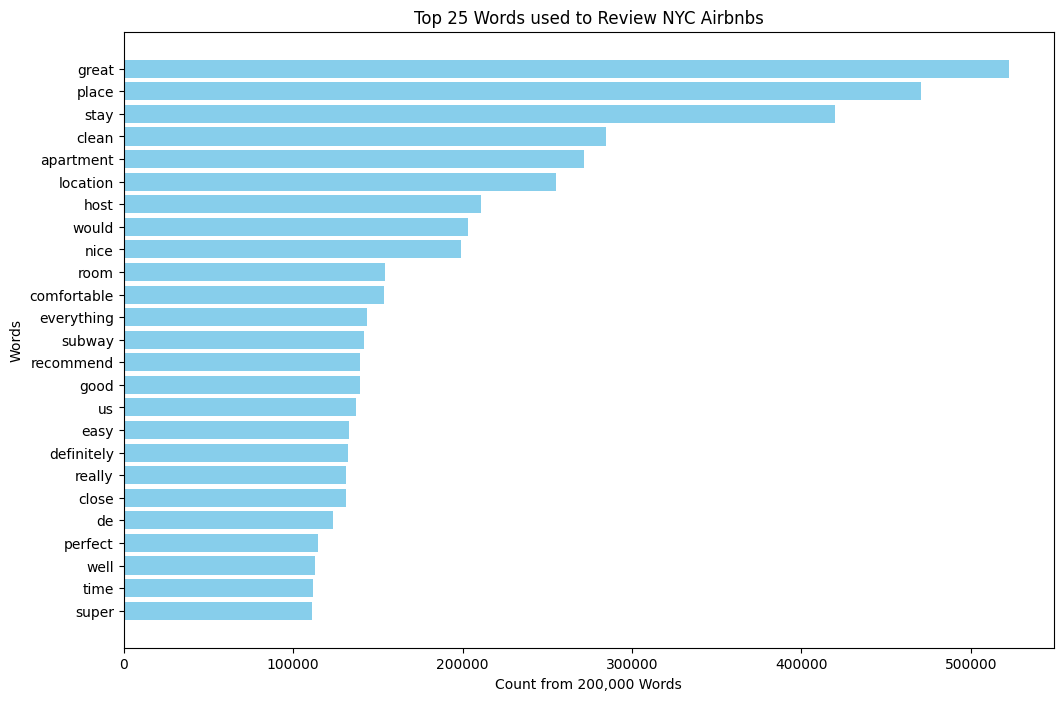

In [ ]:
import matplotlib.pyplot as plt

# Convert Spark DataFrame to Pandas DataFrame
pdf = top_25_df_renamed.toPandas()

# Plotting
plt.figure(figsize=(12,8))
plt.barh(pdf['Words'], pdf['Count'], color='skyblue')
plt.xlabel('Count from 200,000 Words')
plt.ylabel('Words')
plt.title('Top 25 Words used to Review NYC Airbnbs')
plt.gca().invert_yaxis()  # This is to have the word with the highest count at the top
plt.show()


In [ ]:
import pandas as pd

pdataframe = top_25_df_renamed.select("Words", "Count").toPandas()


In [ ]:
pdataframe.to_csv('nlp_words_df.csv', index=False)

In [ ]:
# To be able to download CSV file from Google Colab
from google.colab import files
files.download('nlp_words_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **Sentiement Analysis Price to Top Review Words**

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
# initialize the analyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

In [ ]:
!pip install textblob
from textblob import TextBlob


In [ ]:
from pyspark.sql.functions import udf
from pyspark.sql.types import FloatType

# Define UDFs for various sentiment scores
@udf(FloatType())
def sentiment_neu(text):
    analysis = TextBlob(text)
    return float(1 - (analysis.sentiment.polarity + 1) / 2 - (1 - (analysis.sentiment.polarity + 1) / 2))

@udf(FloatType())
def sentiment_pos(text):
    analysis = TextBlob(text)
    return float((analysis.sentiment.polarity + 1) / 2)

@udf(FloatType())
def sentiment_compound(text):
    return float(TextBlob(text).sentiment.polarity)



In [ ]:
# Adding sentiment columns to the DataFrame
joined_df = joined_reviews_df.withColumn("sentiment_neu", sentiment_neu(joined_reviews_df.comments))
joined_df = joined_reviews_df.withColumn("sentiment_pos", sentiment_pos(joined_reviews_df.comments))
joined_df = joined_reviews_df.withColumn("sentiment_compound", sentiment_compound(joined_reviews_df.comments))


In [ ]:
joined_df.show()


+----------+-------+--------------------+--------+----------+-----------+-------------+--------------------+------------------+
|listing_id|  price|         listing_url|      id|      date|reviewer_id|reviewer_name|            comments|sentiment_compound|
+----------+-------+--------------------+--------+----------+-----------+-------------+--------------------+------------------+
|      2595|$240.00|https://www.airbn...|   17857|2009-11-21|      50679|         Jean|Notre séjour de t...|               0.0|
|      2595|$240.00|https://www.airbn...|   19176|2009-12-05|      53267|         Cate|   Great experience.|               0.8|
|      2595|$240.00|https://www.airbn...|   19760|2009-12-10|      38960|        Anita|I've stayed with ...|        0.41012397|
|      2595|$240.00|https://www.airbn...|   34320|2010-04-09|      71130|      Kai-Uwe|We've been stayin...|          0.266875|
|      2595|$240.00|https://www.airbn...|   46312|2010-05-25|     117113|       Alicia|We had a wonderfu

In [ ]:
import pandas as pd

pdf = joined_df.select("listing_id", "price", "sentiment_compound", "listing_url" ).toPandas()


In [ ]:
# Convert the price column to a numeric value, removing any non-numeric characters like '$' or ','.
pdf['price'] = pd.to_numeric(pdf['price'].str.replace('[\$,]', '', regex=True), errors='coerce')


In [ ]:
pdf.to_csv('compund_df.csv', index=False)


In [ ]:
# To be able to download CSV file from Google Colab
from google.colab import files
files.download('compund_df.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

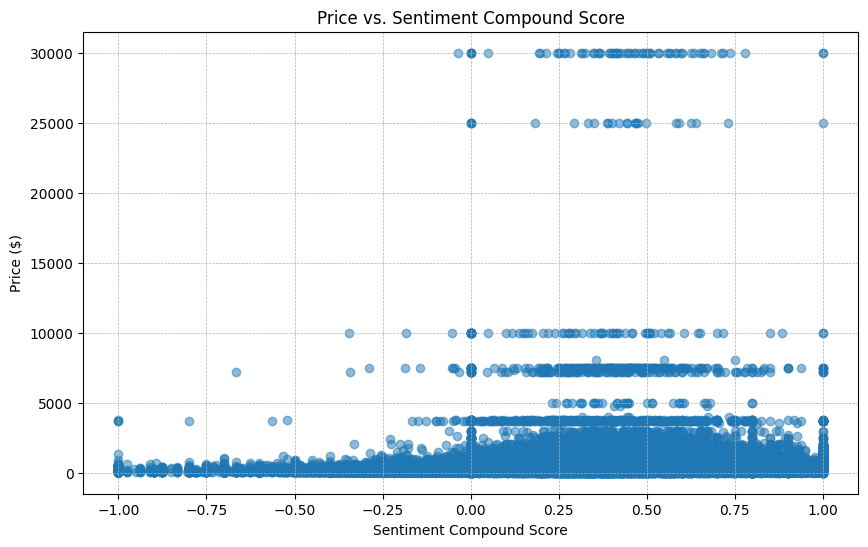

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.scatter(pdf['sentiment_compound'], pdf['price'], alpha=0.5)
plt.title('Price vs. Sentiment Compound Score')
plt.xlabel('Sentiment Compound Score')
plt.ylabel('Price ($)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.show()


In [ ]:
# Stop the Spark session when you're done
spark.stop()

# New Section